# Test of topological clustering algorithm

In [2]:
import tensorflow as tf
print(f"Tensorflow version : {tf.__version__}")

Tensorflow version : 2.2.0-rc1


In [3]:
from ipynb.fs.full.clustering import cluster_maker, cluster_splitter, scalar_features, tf_serialize_example

Tensorflow version : 2.2.0-rc1


## Create mock data

In [4]:
TSEED = tf.constant(1000., tf.float32)
TNEIGHBOR = tf.constant(100., tf.float32)
TCELL = tf.constant(50., tf.float32)

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
np.random.seed(42)

X = np.vstack((np.random.multivariate_normal(mean=[2+3,3+2], cov=[[1,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[2+3,7+2], cov=[[0.7,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[8+3,4+2], cov=[[1,0],[0,1]], size=10000),
               np.random.multivariate_normal(mean=[15,15], cov=[[1,0],[0,1]], size=15000)))
A = plt.hist2d(X[:,0], X[:,1], bins=20, range=[[0, 20], [0, 20]])[0]
# plt.imshow(A)
# B = A[..., np.newaxis]
A[1:3,6] = 1.5*TNEIGHBOR
A[1,7:9] = 1.5*TCELL
A[2,5] = 0
A[3,16] = 2*TSEED

B = A.astype(np.float32)
np.shape(B)

(20, 20)

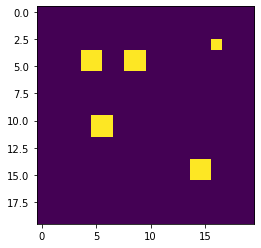

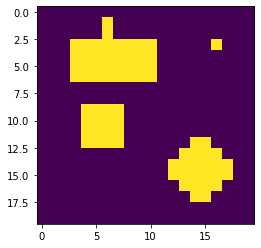

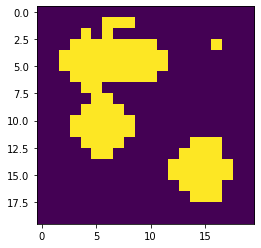

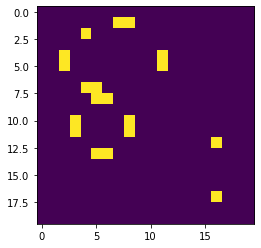

In [6]:
plt.imshow(A > TSEED)
plt.show()
plt.imshow(A > TNEIGHBOR)
plt.show()
plt.imshow(A > TCELL)
plt.show()
plt.imshow((A > TCELL) & (A <= TNEIGHBOR))
plt.show()

In [7]:
# good values to test if recursive function works
# d = {'image': tf.expand_dims(tf.constant(B), axis=0)}
d = {'image': tf.expand_dims(tf.constant(B), axis=0),
     'eventId': tf.constant([[0]], tf.int64),
     'tseed': tf.constant([[1000.]], tf.float32),
     'tneighbour': tf.constant([[100.]], tf.float32),
     'tcell': tf.constant([[50.]], tf.float32),
     'tenergy': tf.constant([[5e3]], tf.float32),
     'tlocmax': tf.constant([[100]], tf.float32),
     'tnum': tf.constant([[3]], tf.int32)}

dataset = tf.data.Dataset.from_tensor_slices(d)
dataset

<TensorSliceDataset shapes: {image: (20, 20), eventId: (1,), tseed: (1,), tneighbour: (1,), tcell: (1,), tenergy: (1,), tlocmax: (1,), tnum: (1,)}, types: {image: tf.float32, eventId: tf.int64, tseed: tf.float32, tneighbour: tf.float32, tcell: tf.float32, tenergy: tf.float32, tlocmax: tf.float32, tnum: tf.int32}>

In [8]:
features_dataset = dataset.map(lambda x: cluster_maker(x, 'image')).map(lambda x: cluster_splitter(x, 'image')) #.map(scalar_features)

W0519 11:38:52.662462 139925393745728 ag_logging.py:146] AutoGraph could not transform <function <lambda> at 0x7f40880dea60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f40880dea60>. It was defined on this line: features_dataset = dataset.map(lambda x: cluster_maker(x, 'image')).map(lambda x: cluster_splitter(x, 'image')) #.map(scalar_features)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f40880dea60>. It was defined on this line: features_dataset = dataset.map(lambda x: cluster_maker(x, 'image')).map(lambda x: cluster_splitter(x, 'image')) #.map(scalar_features)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W0519 11:38:53.318035 139925393745728 ag_logging.py:146] AutoGraph could not transform <function <lambda> at 0x7f404c0aed08> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f404c0aed08>. It was defined on this line: features_dataset = dataset.map(lambda x: cluster_maker(x, 'image')).map(lambda x: cluster_splitter(x, 'image')) #.map(scalar_features)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f404c0aed08>. It was defined on this line: features_dataset = dataset.map(lambda x: cluster_maker(x, 'image')).map(lambda x: cluster_splitter(x, 'image')) #.map(scalar_features)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


locmax [[3 4 9]
 [3 5 5]
 [4 10 6]
 [5 15 14]]
seedlist [[6 4 9]
 [7 5 5]
 [8 10 6]
 [9 15 14]]


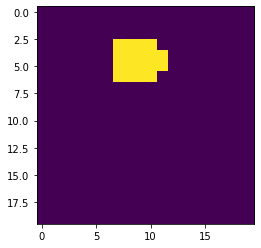

In [18]:
for x in features_dataset:
    C = x['cluster'].numpy().astype(int)
    Cl = C[C[...,0]==]
    sp = tf.SparseTensor(Cl[:, 1:3], Cl[:,0], dense_shape=[20,20])
    A1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
    plt.imshow(A1_dense)

In [42]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)

KeyError: 'feature'

In [8]:
for i in serialized_features_dataset:
    print(i)

NameError: name 'serialized_features_dataset' is not defined

In [11]:
filename = 'test123.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

In [12]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "C_hot"
    value {
      float_list {
        value: 0.11434561014175415
        value: 0.15704411268234253
        value: 0.12291809916496277
      }
    }
  }
  feature {
    key: "C_rad_mean"
    value {
      float_list {
        value: 1.34567391872406
        value: 1.0861921310424805
        value: 1.2647727727890015
      }
    }
  }
  feature {
    key: "C_sum"
    value {
      float_list {
        value: 5221.013671875
        value: 4390.486328125
        value: 7265.0
      }
    }
  }
  feature {
    key: "S_hot"
    value {
      float_list {
        value: 0.10960421711206436
        value: 0.15398773550987244
        value: 0.12201953679323196
      }
    }
  }
  feature {
    key: "S_rad_mean"
    value {
      float_list {
        value: 1.4100439548492432
        value: 1.11213219165802
        value: 1.2768449783325195
      }
    }
  }
  feature {
    key: "S_sum"
    value {
      float_list {
        value: 10893.7412109375
     

In [10]:
# %timeit dataset.map(cluster_maker).map(cluster_splitter).map(scalar_features)

In [11]:
# def func():
#     for parsed in dataset.take(1):
#         output = cluster_maker(parsed)
#         output2 = cluster_splitter(output)
#         output3 = scalar_features(output2)

In [12]:
# %timeit func()

In [17]:
for output in features_dataset.take(1):
    output
#     print(tf.shape(output['proto']))
#     cluster_splitter(output)

In [18]:
# output = cluster_maker({'image': tf.constant(B)})

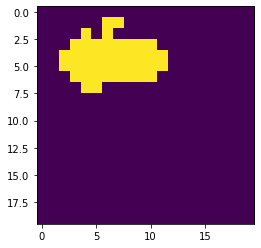

In [20]:
A = output['proto'].numpy()
# A1 = A[A[...,3] == 0][...,:3]
# A2 = A[A[...,3] == 1][...,:3]
sp = tf.SparseTensor(A1[...,1:3], A1[...,0], dense_shape=[20,20])
A1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(A1_dense)

In [227]:
# sp = tf.SparseTensor(A2[...,1:3], A2[...,0], dense_shape=[HEIGHT,WIDTH])
# A2_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
# plt.imshow(A2_dense)

In [228]:
# output2['cluster']

In [229]:
# output = cluster_maker({'image': B})
# output2 = cluster_splitter(output)
# output2

In [230]:
# scalar_features(output2)

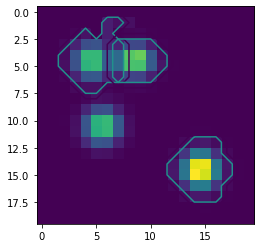

In [231]:
C = output['cluster'].numpy()
# plt.
# print(A)
# A = A[...,1:]
C1 = C[C[...,3] == 0][...,:3]
C2 = C[C[...,3] == 1][...,:3]
plt.imshow(output['image'].numpy()[:,:,0])
for i in np.unique(C1[:,0], axis=0):
    x = C1[C1[...,0] == i]
# C1 = np.unique(C1, axis=0)
# C2 = np.unique(C2, axis=0)
# print(A1)
    sp = tf.SparseTensor(x[...,1:3], x[...,0], dense_shape=[20,20])
    C1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
    plt.contour(C1_dense, levels=1)


In [28]:
from array import array
C = output['cluster'].numpy()

h = ROOT.TH2F("","", 20, 0., 19., 20, 0., 19.)
c = ROOT.TCanvas("c1","c1", 800, 400)
c.Divide(2)
ROOT.gStyle.SetOptStat(0)
for l in range(2):
    c.cd(l+1)
    ROOT.gPad.SetLeftMargin(0.05)
    ROOT.gPad.SetBottomMargin(0.05)
    ROOT.gPad.SetRightMargin(0.15)
    ROOT.gPad.SetTopMargin(0.15)
    Cl = C[C[...,3]==l]
    idx = np.array([1,2,4])
    hk = []
    u = np.unique(C1[:,0], axis=0).astype(int)
    htot = h.Clone()
    arr = array('d',[50])
    for k in range(len(u)):
        for i,j,x in Cl[Cl[...,0]==u[k]][:,idx]:
            hk.append(h.Clone())
            hk[k].Fill(j,i,x)
            htot.Add(hk[k])
    htot.DrawCopy("COLZ")

    for k in range(len(u)):
        hk[k].SetLineColor(ROOT.kRed)
        hk[k].SetLineWidth(2)
        hk[k].SetContour(1, arr)
        hk[k].DrawCopy("cont3 list same")

c.Draw()

IndexError: index 3 is out of bounds for axis 1 with size 3

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [157]:
C = output['cluster'].numpy()
# print(A)
# A = A[...,1:]
C1 = C[C[...,3] == 0][...,:3]
C2 = C[C[...,3] == 1][...,:3]
# A1 = np.unique(A1, axis=0)
# A2 = np.unique(A2, axis=0)
# print(A1)

sp = tf.SparseTensor(C1[...,1:3], C1[...,0], dense_shape=[20,20])
C1_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C1_dense)

InvalidArgumentError: indices[9] = [3,7] is repeated [Op:SparseToDense]

2020-05-17 14:04:36.653701: W tensorflow/core/framework/op_kernel.cc:1752] OP_REQUIRES failed at sparse_to_dense_op.cc:136 : Invalid argument: indices[9] = [3,7] is repeated


In [ ]:
sp = tf.SparseTensor(C2[...,1:3], C2[...,0], dense_shape=[HEIGHT,WIDTH])
C2_dense = tf.sparse.to_dense(tf.sparse.reorder(sp))
plt.imshow(C2_dense)

## Unit testing

In [ ]:
def test_sorting():
    # arrange
    image = tf.constant([[[3., 2.], [6., 1.]], [[5., 8.], [7., 4.]]])
    TSEED = 4.
    seed_list = tf.where(tf.math.greater(image, TSEED))
    seed_len = 4
    
    # act
    sorted_seedlist = sorting(seed_list, seed_len, image)
    
    # assert
    assert tf.equal(sorted_seedlist, tf.constant([[1,0,1], [1,1,0], [0,1,0], [1,0,0]], tf.int64)).numpy().all()

In [ ]:
def test_neighbors():
    # arrange
    index = tf.constant([0,0,0], tf.int64)
    seed_list = tf.constant([[1,0,0], [1,1,0], [1,2,0]], tf.int64)
    
    # act
    neigh = neighbors(index, seed_list)
    
    # assert
    assert tf.equal(neigh, tf.constant([[0,0,1], [0,1,0]], tf.int64)).numpy().all()

In [ ]:
test_neighbors()
# test_sorting()

In [ ]:
tf.shape([[1,2], [4,5]])[0].numpy()

In [4]:
a = tf.constant([6, 5, 4, 3, 2, 1])
c = lambda a: tf.not_equal(tf.size(a), 0)
def b(a): tf.print(a); return [tf.strided_slice(a, [0], [-1], [1])]
r = tf.while_loop(c, b, [a])

[6 5 4 3 2 1]
[6 5 4 3 2]
[6 5 4 3]
[6 5 4]
[6 5]
[6]


In [5]:
tf.constant([[1000.]], tf.float32)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1000.]], dtype=float32)>

In [6]:
tf.where(tf.greater(a, 3))

<tf.Tensor: shape=(3, 1), dtype=int64, numpy=
array([[0],
       [1],
       [2]])>

In [7]:
a.dtype

tf.int32

In [6]:
import tensorflow as tf
from skimage.measure import label

import numpy as np
mask = np.zeros([4,4])
mask[1:3,1] = 1; mask[3,2] = 1; mask[0,3] = 1
mask

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [9]:
f = lambda x: label(x, connectivity=2)
labels = tf.numpy_function(f, [mask], Tout=tf.int64)

In [10]:
labels

<tf.Tensor: shape=(4, 4), dtype=int64, numpy=
array([[0, 0, 0, 1],
       [0, 2, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 2, 0]])>

In [21]:
import matplotlib.pyplot as plt

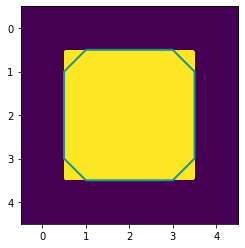

In [22]:
plt.contour(labels[:,:,0], levels=1, linewidths=2)
plt.imshow(labels[:,:,0])

In [23]:
import ROOT

Welcome to JupyROOT 6.18/00


In [65]:
h = ROOT.TH2F("","", 5, 0., 4., 5, 0., 4.)

In [66]:
for i in range(1,4):
    for j in range(1,4):
        print(i,j)
        h.Fill(i,j)

1 1
1 2
1 3
2 1
2 2
2 3
3 1
3 2
3 3


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


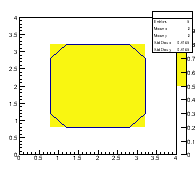

In [86]:
from array import array
c = ROOT.TCanvas("c1","c1", 200, 200)
# h.SetContourLevel(0, 2.);
arr = array('d',[0.5])
h.SetContour(1, arr)
h.DrawCopy("colz");
h.Draw("cont3 list same")
c.Draw()